<a href="https://colab.research.google.com/github/leyixu21/master_thesis/blob/main/clean_flickr_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparations

In [ ]:
! pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 7.1 MB/s 
     |████████████████████████████████| 6.3 MB 46.3 MB/s 
     |████████████████████████████████| 16.7 MB 44.2 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# path='/content/drive/MyDrive/master_thesis_data/'
path='/content/drive/MyDrive/master_thesis_data/newyork_zurich/'

Mounted at /content/drive


In [ ]:
import pandas as pd
from pandas.io.formats.format import NA
import numpy as np
import re
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
import pickle
import folium
import geopandas as gpd

# Preprocess Flick Data

## Clean Data in Each Year

In [47]:
# read data
# output_geojson = 'london_flickr_'
output_geojson = 'zurich_flickr_'
y = 2012

gdf = gpd.read_file(path+output_geojson+str(y)+'.geojson')

# get column names
gdf.columns

Index(['Unnamed: 0', 'accuracy', 'context', 'datetaken',
       'datetakengranularity', 'datetakenunknown', 'farm', 'geo_is_contact',
       'geo_is_family', 'geo_is_friend', 'geo_is_public', 'height_n', 'id',
       'isfamily', 'isfriend', 'ispublic', 'latitude', 'license', 'longitude',
       'machine_tags', 'owner', 'place_id', 'secret', 'server', 'tags',
       'title', 'url_n', 'views', 'width_n', 'woeid', 'geometry'],
      dtype='object')

In [48]:
# select necessary columns
gdf = gdf[['owner', 'accuracy', 'datetaken', 'datetakenunknown', 'tags', 'title', 'geometry']]

# convert string to datetime format
gdf['datetaken'] = pd.to_datetime(gdf['datetaken'], format='%Y-%m-%d %H:%M:%S')
# get date
gdf['date'] = gdf['datetaken'].apply(lambda x: x.date())
# sort by datetaken
gdf = gdf.sort_values(by='datetaken')

In [49]:
# remove photos with no tags
gdf = gdf.dropna(subset=['tags'])

In [50]:
# remove photos with accuracy lower than 14
gdf = gdf[gdf['accuracy']>=14]

### Clean Tags

In [51]:
# remove non-English tags and tags with non-Ascii characters, special characters, numbers, and stop-word

# define a function to detect non-Ascii characters
def containsNonAscii(s):
  return any(ord(i)>127 for i in s)

# define a function to detect special characters and numbers
def containsNonSpecialChar(s):
  return bool(re.match('^[a-zA-Z]*$',s))

# define a function to detect stop-words
def containsNonStopW(s):
  return s != 'a' and s != 'an' and s != 'the'

# define a function to detect general place names
def containsNonGeneralP(s):
  # general_places = ['britain', 'united', 'kingdom', 'uk', 'england', 'london']   # London
  general_places = ['switzerland', 'swiss', 'schweiz', 'suisse', 'zurich', 'zuerich', 'zueri', 'zurigo']   # Zurich
  return all(x not in s for x in general_places)

# define a function to detect irrelevant tags
def containsNonIrreT(s):
  irrelevant = ['nikon', 'iphoneography', 'flickr', 'instagram']
  return all(x not in s for x in irrelevant)

for i, row in gdf.iterrows():
  # split the tag string to the list
  words = row['tags'].split()
  cleaned_words = [word for word in words if not containsNonAscii(word)]
  cleaned_words = [word for word in cleaned_words if containsNonSpecialChar(word)]
  cleaned_words = [word for word in cleaned_words if containsNonStopW(word)]
  cleaned_words = [word for word in cleaned_words if containsNonGeneralP(word)]
  cleaned_words = [word for word in cleaned_words if containsNonIrreT(word)]
  # remove duplicates in the same tag list
  cleaned_words = list(set(cleaned_words))
  # convert the tag list back to the string
  cleaned_words = ' '.join(cleaned_words)
  gdf['tags'][i] = cleaned_words

# remove photos with no tags again
gdf = gdf.dropna(subset=['tags'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Clean Users

In [52]:
# remove duplicates
gdf = gdf.drop_duplicates(subset=['owner', 'tags', 'datetaken'])

In [53]:
# group data by users
gdf_gb_users = gdf.groupby('owner')

# get the list of users
users = list(gdf_gb_users.groups.keys())

In [54]:
# get users less than 5 photos in total at different places over a 24-h period
# iterate the users
for i in users:
  user = gdf_gb_users.get_group(i)
  # group data of the specific user by date
  user_gb_date = user.groupby('date', as_index=False)
  # count the number of photos this user took each day
  user_gb_date_count = user_gb_date.count()
  # get the list of dates when the photos were less than 5
  date_sparse = user_gb_date_count[user_gb_date_count['tags'] < 5].date.to_list()
  # remove users who uploaded sparse photos within a day
  gdf = gdf[(gdf['owner'] != i) | (~gdf['date'].isin(date_sparse))]


# group data by users again
gdf_gb_users = gdf.groupby('owner', as_index=False)

# get the list of users
users = list(gdf_gb_users.groups.keys())

In [55]:
# remove prolific users who uploaded more than 5% photos of the dataset
# count the number of photos each user uploaded
gdf_gb_users_count = pd.DataFrame(gdf_gb_users.count())
# calculate the percent of photos each user uploaded
gdf_gb_users_count['percent'] = (gdf_gb_users_count['tags'] / gdf_gb_users_count['tags'].sum()) * 100
gdf_gb_users_count = gdf_gb_users_count.sort_values('percent', ascending=False)

# get the id of users who uploaded too many photos
users_prolific = gdf_gb_users_count[gdf_gb_users_count['percent'] > 5].owner
# remove prolific users
gdf = gdf[~gdf['owner'].isin(users_prolific)]


In [56]:
# # save semi-cleaned data from 2012 to 2021 as pkl
# gdf.to_pickle(path+output_geojson+'semi_'+str(y)+'.pkl')


## Clean the Whole Data

In [57]:
# # combine 10-year data
# gdf = []
# for y in range(2012, 2022):
#   gdf_y = pd. read_pickle(path+output_geojson+'semi_'+str(y)+'.pkl')
#   gdf.append(gdf_y)
# gdf = pd.concat(gdf)

In [ ]:
# group data by users
gdf_gb_users = gdf.groupby('owner', as_index=False)

# get the list of users
users = list(gdf_gb_users.groups.keys())


# get all tags
tags = list(gdf['tags'].apply(lambda x: x.split()))
# flatten the tags list to 1d
tags = list(np.concatenate(tags).flat)

# count tags
tags_count = Counter(tags)

# get the list of unique tags
tags_unique = list(tags_count.keys())

In [58]:
# Remove tags with the coefficient variation larger than 200 to reduce contribution bias
# create a dictionary to store the usage frequency of tags over users
tags_freq = {}
for i in tags_unique:
  # create a list to store the usage frequency of each tag
  tag_users = []
  for j in users:
    user = gdf_gb_users.get_group(j)
    # get the tags used by the user
    user_tags = list(user['tags'].apply(lambda x: x.split()))
    user_tags = list(np.concatenate(user_tags).flat)
    # get the frequency of the tag used by the user
    freq = user_tags.count(i)
    tag_users.append(freq)
  tags_freq[i] = tag_users

#convert the dictionary to the dataframe
tags_freq = pd.DataFrame(tags_freq)



In [62]:
#define function to calculate cv
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100 

# get the coefficient of variation of tags based on the frequency
tags_cv = tags_freq.apply(cv)

# remove tags based on cv
# gdf = 

# remove photos with no tags again
gdf = gdf.dropna(subset=['tags'])

In [63]:
tags_cv.sort_values()

zoo                   443.826129
limmat                451.989216
bridge                464.204816
building              498.909923
tram                  505.150951
                        ...     
fin                  1378.404875
solarskistudio       1378.404875
stage                1378.404875
solarskistudiocom    1378.404875
panoramio            1378.404875
Length: 3514, dtype: float64

In [60]:
# group data by users again
gdf_gb_users = gdf.groupby('owner', as_index=False)

# get the list of users
users = list(gdf_gb_users.groups.keys())


# get all tags
tags = list(gdf['tags'].apply(lambda x: x.split()))
# flatten the tags list to 1d
tags = list(np.concatenate(tags).flat)

# count tags
tags_count = Counter(tags)

# get the list of unique tags
tags_unique = list(tags_count.keys())

tags_count.most_common()

[('streetparade', 669),
 ('parade', 571),
 ('girls', 558),
 ('street', 533),
 ('party', 521),
 ('svizzera', 497),
 ('people', 476),
 ('europe', 422),
 ('gallery', 422),
 ('music', 414),
 ('event', 404),
 ('sexy', 368),
 ('techno', 358),
 ('festival', 354),
 ('love', 333),
 ('cute', 331),
 ('house', 327),
 ('tamron', 327),
 ('electronic', 326),
 ('young', 320),
 ('creativemornings', 317),
 ('crowd', 317),
 ('pixel', 317),
 ('picture', 317),
 ('lausanne', 317),
 ('photo', 317),
 ('dancing', 317),
 ('fotos', 317),
 ('photographe', 317),
 ('gorgeous', 317),
 ('pics', 317),
 ('pixellausanne', 317),
 ('women', 317),
 ('bilder', 317),
 ('costume', 288),
 ('ch', 287),
 ('zoo', 280),
 ('creativemorningscom', 278),
 ('suiza', 255),
 ('graffiti', 209),
 ('streetart', 191),
 ('tour', 186),
 ('helvetia', 185),
 ('art', 173),
 ('outdoors', 168),
 ('damen', 167),
 ('imbirch', 167),
 ('interliga', 167),
 ('volleyball', 167),
 ('vbtherwil', 167),
 ('events', 167),
 ('stockcategories', 167),
 ('places',

In [ ]:
# # save cleaned data as pkl
# gdf.to_pickle(path+output_geojson+'cleaned_'+str(y)+'.pkl')


# Visualize Data

In [61]:
# # visualize the distribution of photos taken by the specific user
# user_test = gdf_gb_users.get_group('64639998@N00')

# map = folium.Map(location = [51.9,0], zoom_start = 10)

# for date, title, tags, geometry in user_test[['datetaken', 'title', 'tags', 'geometry']].values:
#     # Place the markers with the popup labels and data
#     folium.Marker(location = [geometry.xy[1][0], geometry.xy[0][0]],
#                   tooltip ='<strong>Date: </strong>{0}<br><strong>Title: </strong>{1}</br><strong>Tags: </strong>{2}'.format(date, title, tags)
#                   ).add_to(map)

# map


In [ ]:
# plot xxx

In [ ]:
# plot the tag profile histogram of all users

In [ ]:
# plot the tag profile histogram of prolific users

In [ ]:
# plot the user profile histogram showing the top 20 prolific users


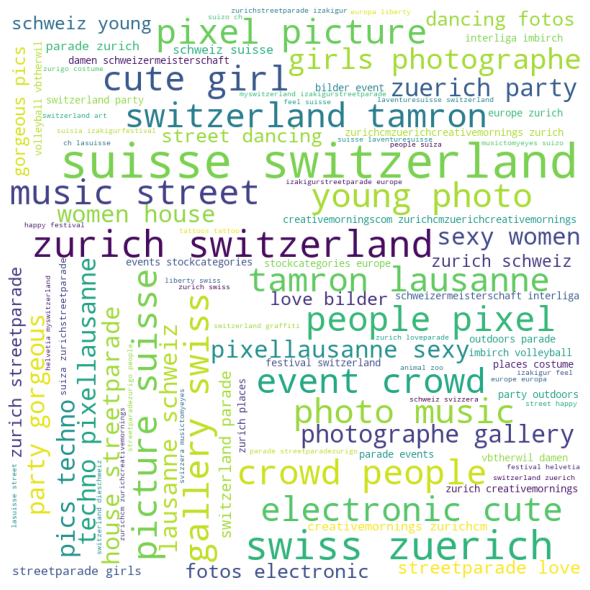

In [ ]:
# Python program to generate WordCloud

# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd


comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in tags:
  # split the value
  tokens = val.split()
  
  # Converts each token into lowercase
  for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()
  
  comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
				background_color ='white',
				stopwords = stopwords,
				min_font_size = 10).generate(comment_words)

# plot the WordCloud image					
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


In [ ]:
tags_count.most_common()

[('svizzera', 727),
 ('street', 704),
 ('streetparade', 684),
 ('nikon', 661),
 ('square', 616),
 ('iphoneography', 597),
 ('squareformat', 591),
 ('instagramapp', 588),
 ('parade', 578),
 ('girls', 559),
 ('party', 533),
 ('zurigo', 527),
 ('europe', 502),
 ('people', 495),
 ('gallery', 432),
 ('music', 419),
 ('event', 404),
 ('love', 383),
 ('sexy', 370),
 ('techno', 360),
 ('festival', 358),
 ('photo', 342),
 ('tamron', 339),
 ('house', 338),
 ('cute', 334),
 ('picture', 333),
 ('electronic', 328),
 ('creativemornings', 322),
 ('young', 321),
 ('women', 319),
 ('lausanne', 319),
 ('crowd', 319),
 ('fotos', 318),
 ('dancing', 318),
 ('gorgeous', 317),
 ('pixellausanne', 317),
 ('photographe', 317),
 ('pics', 317),
 ('bilder', 317),
 ('pixel', 317),
 ('ch', 310),
 ('zoo', 309),
 ('suiza', 297),
 ('flickr', 294),
 ('costume', 289),
 ('creativemorningscom', 280),
 ('graffiti', 249),
 ('streetart', 228),
 ('city', 227),
 ('bw', 220),
 ('art', 217),
 ('architecture', 210),
 ('night', 207

collections.Counter

# Extract Locals and Tourists